# Imports and Functions

In [1]:
import math 
from sklearn.neural_network import MLPClassifier
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 3 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = MLPClassifier(alpha=0.3, max_iter=3000, solver = 'lbfgs')
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
#     find0_5()
#     find_isolated_point()
    
#     print(distfinal)
#     print(probfinal)
#     print(score)
#     print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


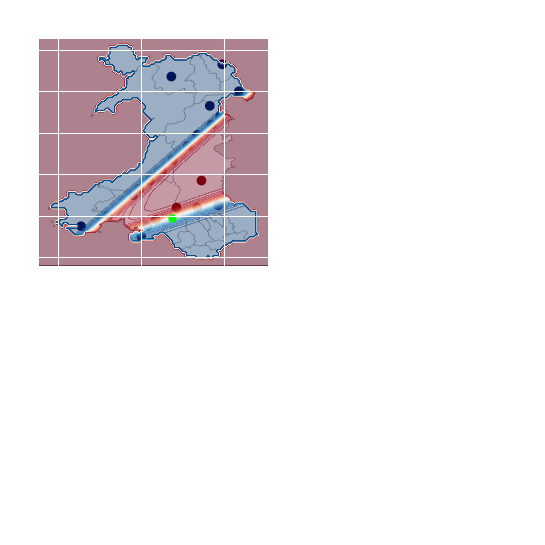

iteration  1
Accuracy is 0.5629686598731013
iteration  2
Accuracy is 0.5831570851759277
iteration  3
Accuracy is 0.5570082676408383
iteration  4
Accuracy is 0.5489328975197078
iteration  5
Accuracy is 0.5727744664487598
iteration  6
Accuracy is 0.5870024995193233
iteration  7
Accuracy is 0.6133435877715824
iteration  8
Accuracy is 0.6143049413574313
iteration  9
Accuracy is 0.6416073831955393
iteration  10
Accuracy is 0.7023649298211883
iteration  11
Accuracy is 0.6977504326091136
iteration  12
Accuracy is 0.6939050182657182
iteration  13
Accuracy is 0.6952509132859066
iteration  14
Accuracy is 0.6975581618919439
iteration  15
Accuracy is 0.6927513939626995
iteration  16
Accuracy is 0.6927513939626995
iteration  17
Accuracy is 0.6998654104979811
iteration  18
Accuracy is 0.6958277254374159
iteration  19
Accuracy is 0.6964045375889252
iteration  20
Accuracy is 0.6937127475485484
iteration  21
Accuracy is 0.6921745818111902
experiment:  1


<IPython.core.display.Javascript object>


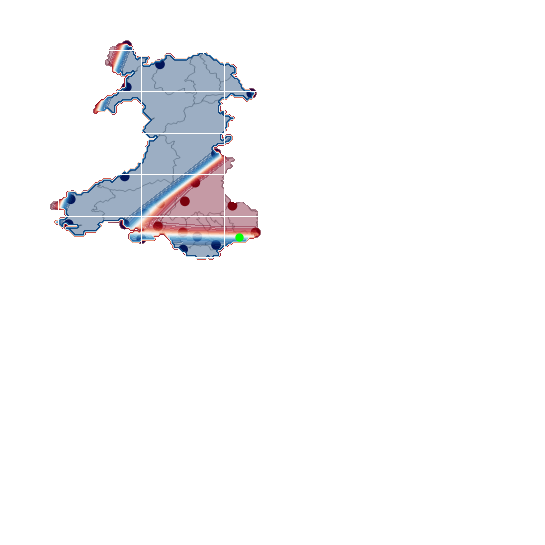

iteration  1
Accuracy is 0.5045183618534897
iteration  2
Accuracy is 0.5585464333781965
iteration  3
Accuracy is 0.60680638338781
iteration  4
Accuracy is 0.6314170351855413
iteration  5
Accuracy is 0.6481445875793117
iteration  6
Accuracy is 0.6293020572966738
iteration  7
Accuracy is 0.6758315708517593
iteration  8
Accuracy is 0.661603537781196
iteration  9
Accuracy is 0.6604499134781773
iteration  10
Accuracy is 0.6244952893674294
iteration  11
Accuracy is 0.6314170351855413
iteration  12
Accuracy is 0.6562199577004422
iteration  13
Accuracy is 0.6104595270140357
iteration  14
Accuracy is 0.6352624495289367
iteration  15
Accuracy is 0.644491443953086
iteration  16
Accuracy is 0.6541049798115747
iteration  17
Accuracy is 0.6560276869832724
iteration  18
Accuracy is 0.6808306094981734
iteration  19
Accuracy is 0.6741011343972313
iteration  20
Accuracy is 0.6860219188617573
iteration  21
Accuracy is 0.677754278023457
experiment:  2


<IPython.core.display.Javascript object>


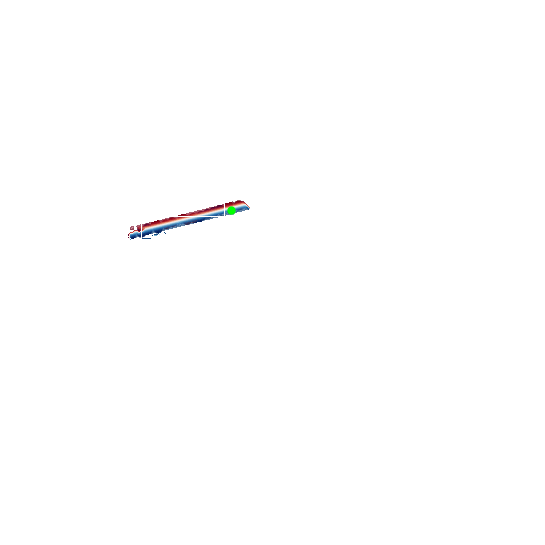

iteration  1
Accuracy is 0.44587579311670833
iteration  2
Accuracy is 0.4479907710055758
iteration  3
Accuracy is 0.45029801961161314
iteration  4
Accuracy is 0.4472216881368968
iteration  5
Accuracy is 0.4443376273793501
iteration  6
Accuracy is 0.445298980965199
iteration  7
Accuracy is 0.4468371467025572
iteration  8
Accuracy is 0.44626033455104785
iteration  9
Accuracy is 0.4468371467025572
iteration  10
Accuracy is 0.44626033455104785
iteration  11
Accuracy is 0.4464526052682177
iteration  12
Accuracy is 0.44626033455104785
iteration  13
Accuracy is 0.4464526052682177
iteration  14
Accuracy is 0.44702941741972696
iteration  15
Accuracy is 0.4468371467025572
iteration  16
Accuracy is 0.44702941741972696
iteration  17
Accuracy is 0.44741395885406654
iteration  18
Accuracy is 0.4472216881368968
iteration  19
Accuracy is 0.4472216881368968
iteration  20
Accuracy is 0.44741395885406654
iteration  21
Accuracy is 0.44741395885406654
experiment:  3


<IPython.core.display.Javascript object>


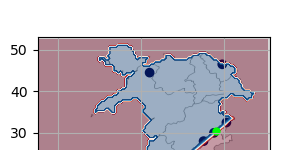

iteration  1
Accuracy is 0.5466256489136705
iteration  2
Accuracy is 0.5960392232263027
iteration  3
Accuracy is 0.6448759853874255
iteration  4
Accuracy is 0.6275716208421458
iteration  5
Accuracy is 0.6118054220342242
iteration  6
Accuracy is 0.6416073831955393
iteration  7
Accuracy is 0.6412228417611998
iteration  8
Accuracy is 0.645260526821765
iteration  9
Accuracy is 0.6450682561045953
iteration  10
Accuracy is 0.6450682561045953
iteration  11
Accuracy is 0.6448759853874255
iteration  12
Accuracy is 0.644491443953086
iteration  13
Accuracy is 0.6450682561045953
iteration  14
Accuracy is 0.6450682561045953
iteration  15
Accuracy is 0.644491443953086
iteration  16
Accuracy is 0.6448759853874255
iteration  17
Accuracy is 0.6446837146702558
iteration  18
Accuracy is 0.644491443953086
iteration  19
Accuracy is 0.6448759853874255
iteration  20
Accuracy is 0.6448759853874255
iteration  21
Accuracy is 0.6448759853874255
experiment:  4


<IPython.core.display.Javascript object>


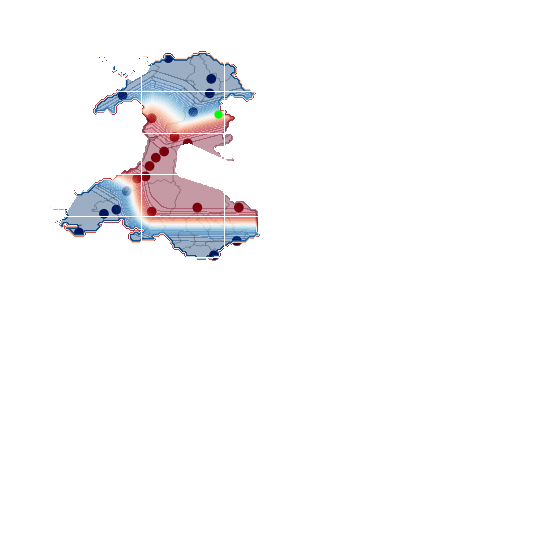

iteration  1
Accuracy is 0.6029609690444145
iteration  2
Accuracy is 0.6164199192462988
iteration  3
Accuracy is 0.6014228033070563
iteration  4
Accuracy is 0.6112286098827149
iteration  5
Accuracy is 0.6131513170544126
iteration  6
Accuracy is 0.6073831955393194
iteration  7
Accuracy is 0.604306864064603
iteration  8
Accuracy is 0.606037300519131
iteration  9
Accuracy is 0.6071909248221495
iteration  10
Accuracy is 0.6058450298019612
iteration  11
Accuracy is 0.6054604883676216
iteration  12
Accuracy is 0.6191117092866757
iteration  13
Accuracy is 0.8090751778504134
iteration  14
Accuracy is 0.7019803883868487
iteration  15
Accuracy is 0.8181119015573928
iteration  16
Accuracy is 0.7879253989617381
iteration  17
Accuracy is 0.6596808306094982
iteration  18
Accuracy is 0.6460296096904441
iteration  19
Accuracy is 0.6708325322053451
iteration  20
Accuracy is 0.7039030955585465
iteration  21
Accuracy is 0.8204191501634301
experiment:  5


<IPython.core.display.Javascript object>


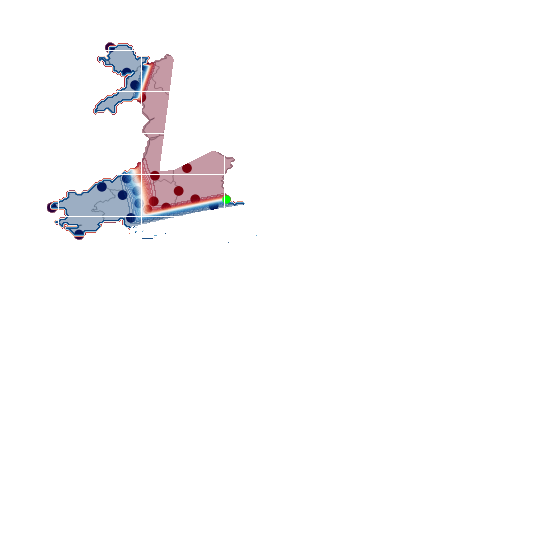

iteration  1
Accuracy is 0.38646414151124786
iteration  2
Accuracy is 0.35896942895597
iteration  3
Accuracy is 0.37646606421841955
iteration  4
Accuracy is 0.47490867140934434
iteration  5
Accuracy is 0.5072101518938665
iteration  6
Accuracy is 0.5166314170351856
iteration  7
Accuracy is 0.5677754278023457
iteration  8
Accuracy is 0.5372043837723515
iteration  9
Accuracy is 0.5548932897519707
iteration  10
Accuracy is 0.5773889636608345
iteration  11
Accuracy is 0.5973851182464911
iteration  12
Accuracy is 0.6058450298019612
iteration  13
Accuracy is 0.5964237646606422
iteration  14
Accuracy is 0.5950778696404537
iteration  15
Accuracy is 0.6069986541049798
iteration  16
Accuracy is 0.610267256296866
iteration  17
Accuracy is 0.621418957892713
iteration  18
Accuracy is 0.6262257258219573
iteration  19
Accuracy is 0.6346856373774274
iteration  20
Accuracy is 0.6304556815996923
iteration  21
Accuracy is 0.6331474716400692
experiment:  6


<IPython.core.display.Javascript object>


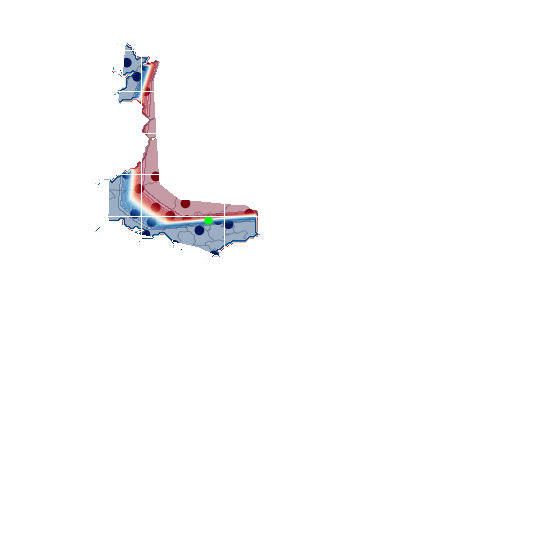

iteration  1
Accuracy is 0.5579696212266871
iteration  2
Accuracy is 0.5618150355700827
iteration  3
Accuracy is 0.5437415881561238
iteration  4
Accuracy is 0.5771966929436647
iteration  5
Accuracy is 0.545279753893482
iteration  6
Accuracy is 0.5829648144587579
iteration  7
Accuracy is 0.6366083445491252
iteration  8
Accuracy is 0.5877715823880023
iteration  9
Accuracy is 0.6237262064987502
iteration  10
Accuracy is 0.6094981734281869
iteration  11
Accuracy is 0.629878869448183
iteration  12
Accuracy is 0.6408383003268602
iteration  13
Accuracy is 0.6362238031147857
iteration  14
Accuracy is 0.6294943280138435
iteration  15
Accuracy is 0.6329552009228995
iteration  16
Accuracy is 0.6396846760238416
iteration  17
Accuracy is 0.635070178811767
iteration  18
Accuracy is 0.6454527975389348
iteration  19
Accuracy is 0.6500672947510094
iteration  20
Accuracy is 0.6494904825995
iteration  21
Accuracy is 0.6491059411651605
experiment:  7


<IPython.core.display.Javascript object>


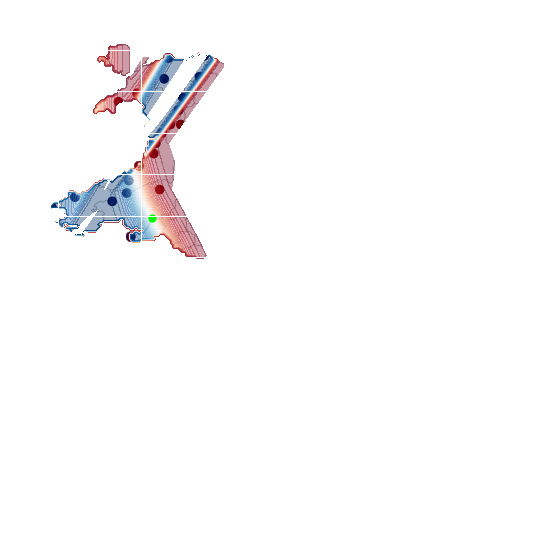

iteration  1
Accuracy is 0.635070178811767
iteration  2
Accuracy is 0.47317823495481637
iteration  3
Accuracy is 0.5195154777927322
iteration  4
Accuracy is 0.48855989232839836
iteration  5
Accuracy is 0.5062487983080177
iteration  6
Accuracy is 0.5245145164391464
iteration  7
Accuracy is 0.5174004999038646
iteration  8
Accuracy is 0.5272063064795232
iteration  9
Accuracy is 0.5252835993078254
iteration  10
Accuracy is 0.5233608921361277
iteration  11
Accuracy is 0.5258604114593347
iteration  12
Accuracy is 0.5285522014997116
iteration  13
Accuracy is 0.5200922899442415
iteration  14
Accuracy is 0.5220149971159392
iteration  15
Accuracy is 0.5245145164391464
iteration  16
Accuracy is 0.5285522014997116
iteration  17
Accuracy is 0.5275908479138627
iteration  18
Accuracy is 0.5285522014997116
iteration  19
Accuracy is 0.5539319361661219
iteration  20
Accuracy is 0.5781580465295135
iteration  21
Accuracy is 0.6037300519130936
experiment:  8


<IPython.core.display.Javascript object>


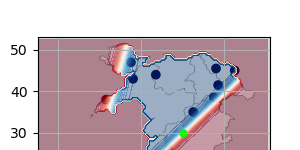

iteration  1
Accuracy is 0.551240146125745
iteration  2
Accuracy is 0.5537396654489521
iteration  3
Accuracy is 0.5589309748125361
iteration  4
Accuracy is 0.5575850797923476
iteration  5
Accuracy is 0.537588925206691
iteration  6
Accuracy is 0.5531628532974427
iteration  7
Accuracy is 0.6127667756200731
iteration  8
Accuracy is 0.6464141511247837
iteration  9
Accuracy is 0.6644875985387425
iteration  10
Accuracy is 0.6514131897711979
iteration  11
Accuracy is 0.646990963276293
iteration  12
Accuracy is 0.65814266487214
iteration  13
Accuracy is 0.6704479907710056
iteration  14
Accuracy is 0.6833301288213806
iteration  15
Accuracy is 0.6844837531243991
iteration  16
Accuracy is 0.6808306094981734
iteration  17
Accuracy is 0.6885214381849645
iteration  18
Accuracy is 0.6837146702557201
iteration  19
Accuracy is 0.6954431840030764
iteration  20
Accuracy is 0.70082676408383
iteration  21
Accuracy is 0.7177465871947702
experiment:  9


<IPython.core.display.Javascript object>


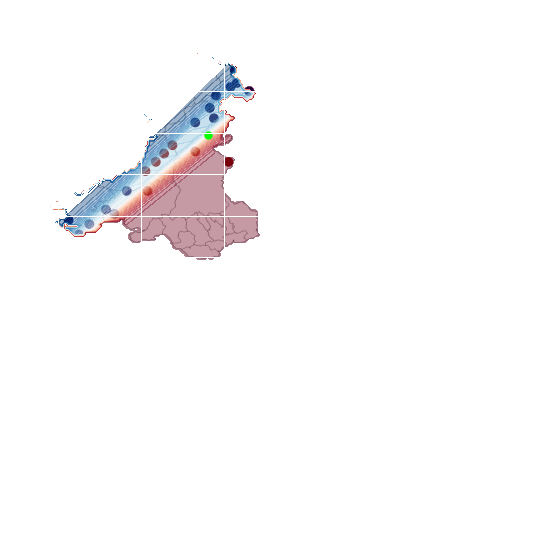

iteration  1
Accuracy is 0.5935397039030955
iteration  2
Accuracy is 0.5335512401461258
iteration  3
Accuracy is 0.5895020188425303
iteration  4
Accuracy is 0.5837338973274371
iteration  5
Accuracy is 0.6108440684483754
iteration  6
Accuracy is 0.5943087867717747
iteration  7
Accuracy is 0.6075754662564892
iteration  8
Accuracy is 0.6094981734281869
iteration  9
Accuracy is 0.6148817535089406
iteration  10
Accuracy is 0.6150740242261103
iteration  11
Accuracy is 0.6073831955393194
iteration  12
Accuracy is 0.6150740242261103
iteration  13
Accuracy is 0.6150740242261103
iteration  14
Accuracy is 0.6150740242261103
iteration  15
Accuracy is 0.6150740242261103
iteration  16
Accuracy is 0.6166121899634686
iteration  17
Accuracy is 0.6150740242261103
iteration  18
Accuracy is 0.6439146318015766
iteration  19
Accuracy is 0.6377619688521439
iteration  20
Accuracy is 0.6431455489328975
iteration  21
Accuracy is 0.639300134589502
experiment:  10


<IPython.core.display.Javascript object>


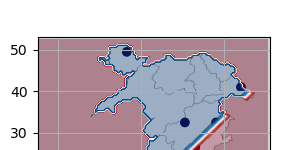

iteration  1
Accuracy is 0.5612382234185733
iteration  2
Accuracy is 0.5429725052874447
iteration  3
Accuracy is 0.6185348971351663
iteration  4
Accuracy is 0.6419919246298789
iteration  5
Accuracy is 0.635070178811767
iteration  6
Accuracy is 0.6429532782157278
iteration  7
Accuracy is 0.6450682561045953
iteration  8
Accuracy is 0.6391078638723322
iteration  9
Accuracy is 0.6435300903672371
iteration  10
Accuracy is 0.6419919246298789
iteration  11
Accuracy is 0.6398769467410114
iteration  12
Accuracy is 0.6417996539127091
iteration  13
Accuracy is 0.6454527975389348
iteration  14
Accuracy is 0.6550663333974236
iteration  15
Accuracy is 0.6817919630840223
iteration  16
Accuracy is 0.7221688136896751
iteration  17
Accuracy is 0.706787156316093
iteration  18
Accuracy is 0.7208229186694867
iteration  19
Accuracy is 0.7271678523360892
iteration  20
Accuracy is 0.7248606037300519
iteration  21
Accuracy is 0.727360123053259
experiment:  11


<IPython.core.display.Javascript object>


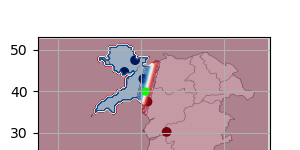

iteration  1
Accuracy is 0.48336858296481444
iteration  2
Accuracy is 0.545279753893482
iteration  3
Accuracy is 0.5716208421457412
iteration  4
Accuracy is 0.5733512786002691
iteration  5
Accuracy is 0.5348971351663142
iteration  6
Accuracy is 0.5220149971159392
iteration  7
Accuracy is 0.5677754278023457
iteration  8
Accuracy is 0.6077677369736589
iteration  9
Accuracy is 0.6071909248221495
iteration  10
Accuracy is 0.6091136319938474
iteration  11
Accuracy is 0.6023841568929053
iteration  12
Accuracy is 0.6100749855796962
iteration  13
Accuracy is 0.6356469909632763
iteration  14
Accuracy is 0.6210344164583734
iteration  15
Accuracy is 0.6260334551047876
iteration  16
Accuracy is 0.6231493943472409
iteration  17
Accuracy is 0.6373774274178042
iteration  18
Accuracy is 0.6441069025187464
iteration  19
Accuracy is 0.6402614881753509
iteration  20
Accuracy is 0.6466064218419535
iteration  21
Accuracy is 0.6467986925591233
experiment:  12


<IPython.core.display.Javascript object>


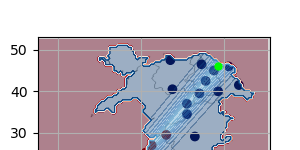

iteration  1
Accuracy is 0.39223226302634107
iteration  2
Accuracy is 0.40434531820803693
iteration  3
Accuracy is 0.41030571044029995
iteration  4
Accuracy is 0.4158815612382234
iteration  5
Accuracy is 0.4243414727936935
iteration  6
Accuracy is 0.4354931743895405
iteration  7
Accuracy is 0.47240915208613726
iteration  8
Accuracy is 0.5427802345702749
iteration  9
Accuracy is 0.5548932897519707
iteration  10
Accuracy is 0.5733512786002691
iteration  11
Accuracy is 0.5873870409536628
iteration  12
Accuracy is 0.5902711017112093
iteration  13
Accuracy is 0.594885598923284
iteration  14
Accuracy is 0.6012305325898866
iteration  15
Accuracy is 0.6150740242261103
iteration  16
Accuracy is 0.6150740242261103
iteration  17
Accuracy is 0.6150740242261103
iteration  18
Accuracy is 0.6150740242261103
iteration  19
Accuracy is 0.6150740242261103
iteration  20
Accuracy is 0.6150740242261103
iteration  21
Accuracy is 0.6150740242261103
experiment:  13


<IPython.core.display.Javascript object>


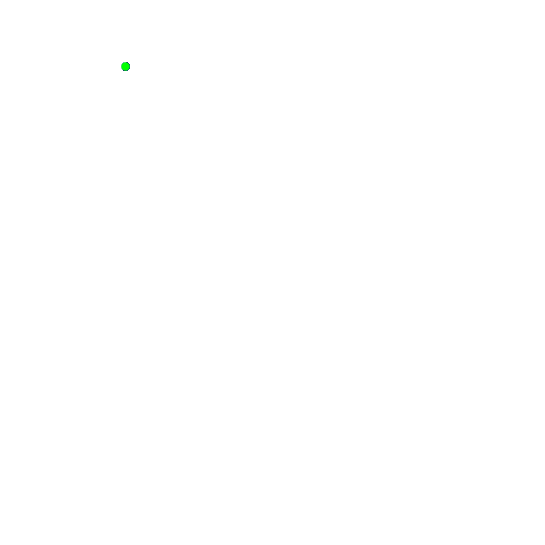

iteration  1
Accuracy is 0.5223995385502788
iteration  2
Accuracy is 0.5518169582772544
iteration  3
Accuracy is 0.5633532013074409
iteration  4
Accuracy is 0.5712363007114016
iteration  5
Accuracy is 0.5833493558930974
iteration  6
Accuracy is 0.5927706210344165
iteration  7
Accuracy is 0.5887329359738512
iteration  8
Accuracy is 0.6048836762161123
iteration  9
Accuracy is 0.6119976927513939
iteration  10
Accuracy is 0.6150740242261103
iteration  11
Accuracy is 0.6150740242261103
iteration  12
Accuracy is 0.6150740242261103
iteration  13
Accuracy is 0.6150740242261103
iteration  14
Accuracy is 0.6150740242261103
iteration  15
Accuracy is 0.6150740242261103
iteration  16
Accuracy is 0.6150740242261103
iteration  17
Accuracy is 0.6150740242261103
iteration  18
Accuracy is 0.6150740242261103
iteration  19
Accuracy is 0.6150740242261103
iteration  20
Accuracy is 0.6150740242261103
iteration  21
Accuracy is 0.6150740242261103
experiment:  14


<IPython.core.display.Javascript object>


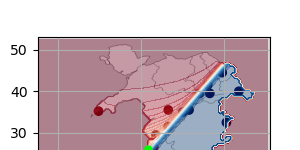

iteration  1
Accuracy is 0.4229955777735051
iteration  2
Accuracy is 0.4993270524899058
iteration  3
Accuracy is 0.464141511247837
iteration  4
Accuracy is 0.4408767544702942
iteration  5
Accuracy is 0.4737550471063257
iteration  6
Accuracy is 0.499134781772736
iteration  7
Accuracy is 0.4422226494904826
iteration  8
Accuracy is 0.4262641799653913
iteration  9
Accuracy is 0.429917323591617
iteration  10
Accuracy is 0.44818304172274565
iteration  11
Accuracy is 0.4545279753893482
iteration  12
Accuracy is 0.4677946548740627
iteration  13
Accuracy is 0.46260334551047877
iteration  14
Accuracy is 0.4924053066717939
iteration  15
Accuracy is 0.4983656989040569
iteration  16
Accuracy is 0.502595654681792
iteration  17
Accuracy is 0.5045183618534897
iteration  18
Accuracy is 0.510286483368583
iteration  19
Accuracy is 0.5054797154393386
iteration  20
Accuracy is 0.5039415497019804
iteration  21
Accuracy is 0.5024033839646221
experiment:  15


<IPython.core.display.Javascript object>


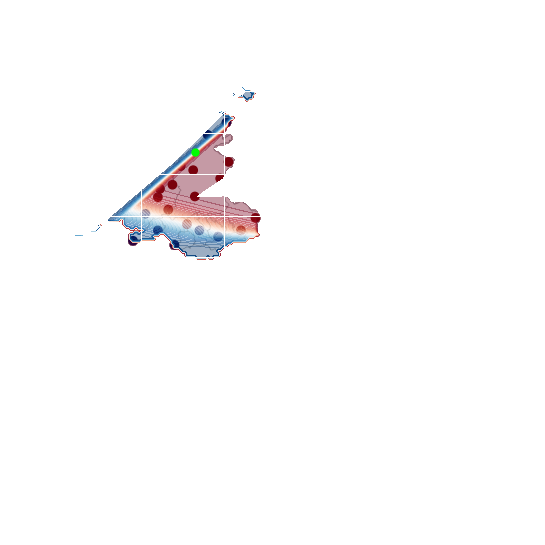

iteration  1
Accuracy is 0.6431455489328975
iteration  2
Accuracy is 0.629878869448183
iteration  3
Accuracy is 0.5956546817919631
iteration  4
Accuracy is 0.5987310132666794
iteration  5
Accuracy is 0.6237262064987502
iteration  6
Accuracy is 0.6158431070947895
iteration  7
Accuracy is 0.631609305902711
iteration  8
Accuracy is 0.6473755047106325
iteration  9
Accuracy is 0.656412228417612
iteration  10
Accuracy is 0.7146702557200538
iteration  11
Accuracy is 0.6925591232455297
iteration  12
Accuracy is 0.7064026148817535
iteration  13
Accuracy is 0.7202461065179773
iteration  14
Accuracy is 0.727360123053259
iteration  15
Accuracy is 0.7192847529321285
iteration  16
Accuracy is 0.7089021342049606
iteration  17
Accuracy is 0.7146702557200538
iteration  18
Accuracy is 0.7144779850028841
iteration  19
Accuracy is 0.7215920015381657
iteration  20
Accuracy is 0.7304364545279753
iteration  21
Accuracy is 0.7246683330128821
experiment:  16


<IPython.core.display.Javascript object>


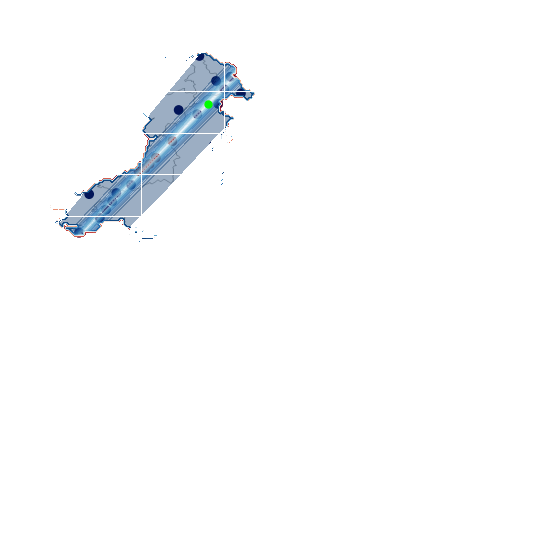

iteration  1
Accuracy is 0.500865218227264
iteration  2
Accuracy is 0.5099019419342434
iteration  3
Accuracy is 0.5220149971159392
iteration  4
Accuracy is 0.5389348202268794
iteration  5
Accuracy is 0.5579696212266871
iteration  6
Accuracy is 0.5910401845798885
iteration  7
Accuracy is 0.5950778696404537
iteration  8
Accuracy is 0.5725821957315901
iteration  9
Accuracy is 0.5835416266102672
iteration  10
Accuracy is 0.5852720630647952
iteration  11
Accuracy is 0.590655643145549
iteration  12
Accuracy is 0.605075946933282
iteration  13
Accuracy is 0.6150740242261103
iteration  14
Accuracy is 0.6087290905595077
iteration  15
Accuracy is 0.6150740242261103
iteration  16
Accuracy is 0.6150740242261103
iteration  17
Accuracy is 0.6150740242261103
iteration  18
Accuracy is 0.6150740242261103
iteration  19
Accuracy is 0.6150740242261103
iteration  20
Accuracy is 0.6150740242261103
iteration  21
Accuracy is 0.6150740242261103
experiment:  17


<IPython.core.display.Javascript object>


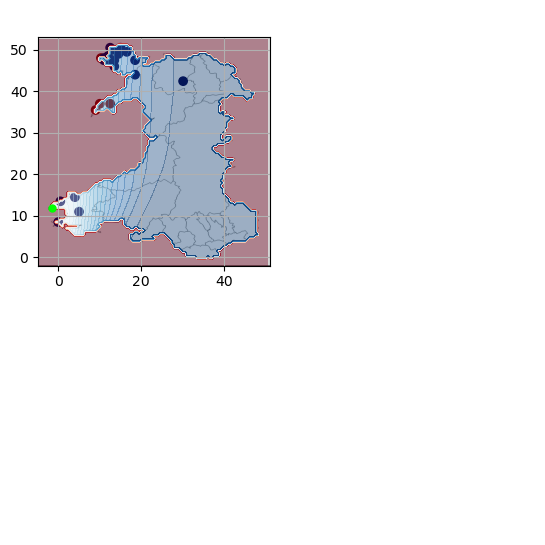

iteration  1
Accuracy is 0.5475870024995193
iteration  2
Accuracy is 0.5808498365698904
iteration  3
Accuracy is 0.6021918861757354
iteration  4
Accuracy is 0.5910401845798885
iteration  5
Accuracy is 0.5954624110747934
iteration  6
Accuracy is 0.5939242453374352
iteration  7
Accuracy is 0.5966160353778119
iteration  8
Accuracy is 0.5945010574889444
iteration  9
Accuracy is 0.6046914054989425
iteration  10
Accuracy is 0.6125745049029033
iteration  11
Accuracy is 0.6073831955393194
iteration  12
Accuracy is 0.6089213612766775
iteration  13
Accuracy is 0.6087290905595077
iteration  14
Accuracy is 0.610267256296866
iteration  15
Accuracy is 0.6144972120746011
iteration  16
Accuracy is 0.6141126706402615
iteration  17
Accuracy is 0.6156508363776196
iteration  18
Accuracy is 0.6150740242261103
iteration  19
Accuracy is 0.6150740242261103
iteration  20
Accuracy is 0.6150740242261103
iteration  21
Accuracy is 0.6150740242261103
experiment:  18


<IPython.core.display.Javascript object>


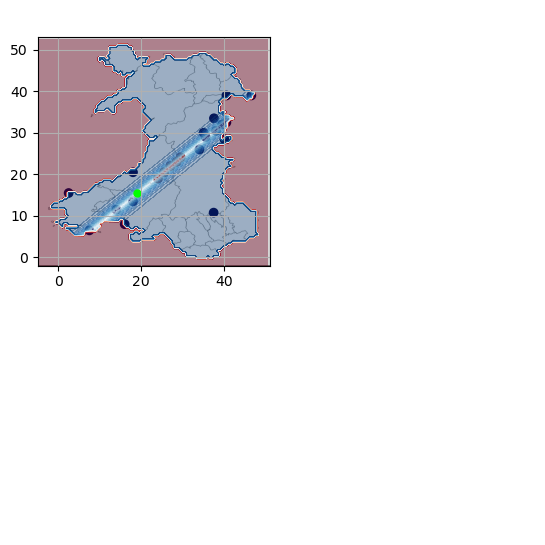

iteration  1
Accuracy is 0.3908863680061527
iteration  2
Accuracy is 0.49125168236877526
iteration  3
Accuracy is 0.4979811574697174
iteration  4
Accuracy is 0.6037300519130936
iteration  5
Accuracy is 0.6083445491251682
iteration  6
Accuracy is 0.6044991347817728
iteration  7
Accuracy is 0.6075754662564892
iteration  8
Accuracy is 0.6071909248221495
iteration  9
Accuracy is 0.6091136319938474
iteration  10
Accuracy is 0.6106517977312056
iteration  11
Accuracy is 0.6106517977312056
iteration  12
Accuracy is 0.6129590463372429
iteration  13
Accuracy is 0.6150740242261103
iteration  14
Accuracy is 0.6150740242261103
iteration  15
Accuracy is 0.6150740242261103
iteration  16
Accuracy is 0.6150740242261103
iteration  17
Accuracy is 0.6150740242261103
iteration  18
Accuracy is 0.6150740242261103
iteration  19
Accuracy is 0.6150740242261103
iteration  20
Accuracy is 0.6150740242261103
iteration  21
Accuracy is 0.6150740242261103
experiment:  19


<IPython.core.display.Javascript object>


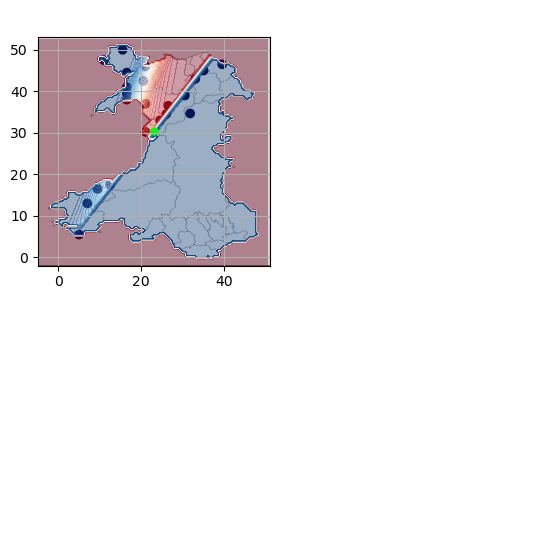

iteration  1
Accuracy is 0.43895404729859644
iteration  2
Accuracy is 0.4604883676216112
iteration  3
Accuracy is 0.4637569698134974
iteration  4
Accuracy is 0.4770236492982119
iteration  5
Accuracy is 0.5081715054797155
iteration  6
Accuracy is 0.5193232070755623
iteration  7
Accuracy is 0.49951932320707554
iteration  8
Accuracy is 0.5166314170351856
iteration  9
Accuracy is 0.5543164776004614
iteration  10
Accuracy is 0.5250913285906557
iteration  11
Accuracy is 0.537588925206691
iteration  12
Accuracy is 0.5429725052874447
iteration  13
Accuracy is 0.5483560853681985
iteration  14
Accuracy is 0.5645068256104595
iteration  15
Accuracy is 0.5662372620649875
iteration  16
Accuracy is 0.5800807537012113
iteration  17
Accuracy is 0.5664295327821572
iteration  18
Accuracy is 0.5679676985195155
iteration  19
Accuracy is 0.5604691405498943
iteration  20
Accuracy is 0.5681599692366852
iteration  21
Accuracy is 0.5681599692366852
experiment:  20


<IPython.core.display.Javascript object>


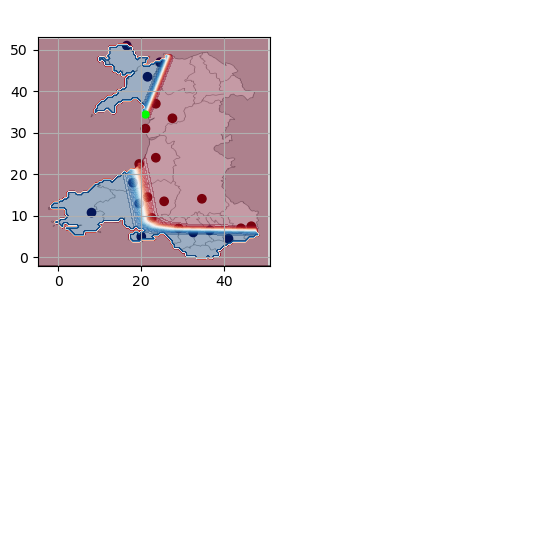

iteration  1
Accuracy is 0.5654681791963084
iteration  2
Accuracy is 0.5533551240146126
iteration  3
Accuracy is 0.5618150355700827
iteration  4
Accuracy is 0.5696981349740434
iteration  5
Accuracy is 0.5206691020957508
iteration  6
Accuracy is 0.5670063449336666
iteration  7
Accuracy is 0.5552778311863104
iteration  8
Accuracy is 0.5839261680446068
iteration  9
Accuracy is 0.5823880023072486
iteration  10
Accuracy is 0.6389155931551624
iteration  11
Accuracy is 0.6554508748317631
iteration  12
Accuracy is 0.6529513555085561
iteration  13
Accuracy is 0.6437223610844068
iteration  14
Accuracy is 0.6508363776196885
iteration  15
Accuracy is 0.6554508748317631
iteration  16
Accuracy is 0.6533358969428956
iteration  17
Accuracy is 0.6604499134781773
iteration  18
Accuracy is 0.6631417035185542
iteration  19
Accuracy is 0.6642953278215727
iteration  20
Accuracy is 0.6667948471447799
iteration  21
Accuracy is 0.6702557200538358


In [7]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 67.03 %
Improvement is = 10.48 %


In [9]:
Results

[[0.5629686598731013,
  0.5831570851759277,
  0.5570082676408383,
  0.5489328975197078,
  0.5727744664487598,
  0.5870024995193233,
  0.6133435877715824,
  0.6143049413574313,
  0.6416073831955393,
  0.7023649298211883,
  0.6977504326091136,
  0.6939050182657182,
  0.6952509132859066,
  0.6975581618919439,
  0.6927513939626995,
  0.6927513939626995,
  0.6998654104979811,
  0.6958277254374159,
  0.6964045375889252,
  0.6937127475485484,
  0.6921745818111902],
 [0.5045183618534897,
  0.5585464333781965,
  0.60680638338781,
  0.6314170351855413,
  0.6481445875793117,
  0.6293020572966738,
  0.6758315708517593,
  0.661603537781196,
  0.6604499134781773,
  0.6244952893674294,
  0.6314170351855413,
  0.6562199577004422,
  0.6104595270140357,
  0.6352624495289367,
  0.644491443953086,
  0.6541049798115747,
  0.6560276869832724,
  0.6808306094981734,
  0.6741011343972313,
  0.6860219188617573,
  0.677754278023457],
 [0.44587579311670833,
  0.4479907710055758,
  0.45029801961161314,
  0.4472216

In [13]:
np.savetxt('Branin_bestnn', Results)

In [11]:
tst = np.loadtxt('Branin_best')

<IPython.core.display.Javascript object>


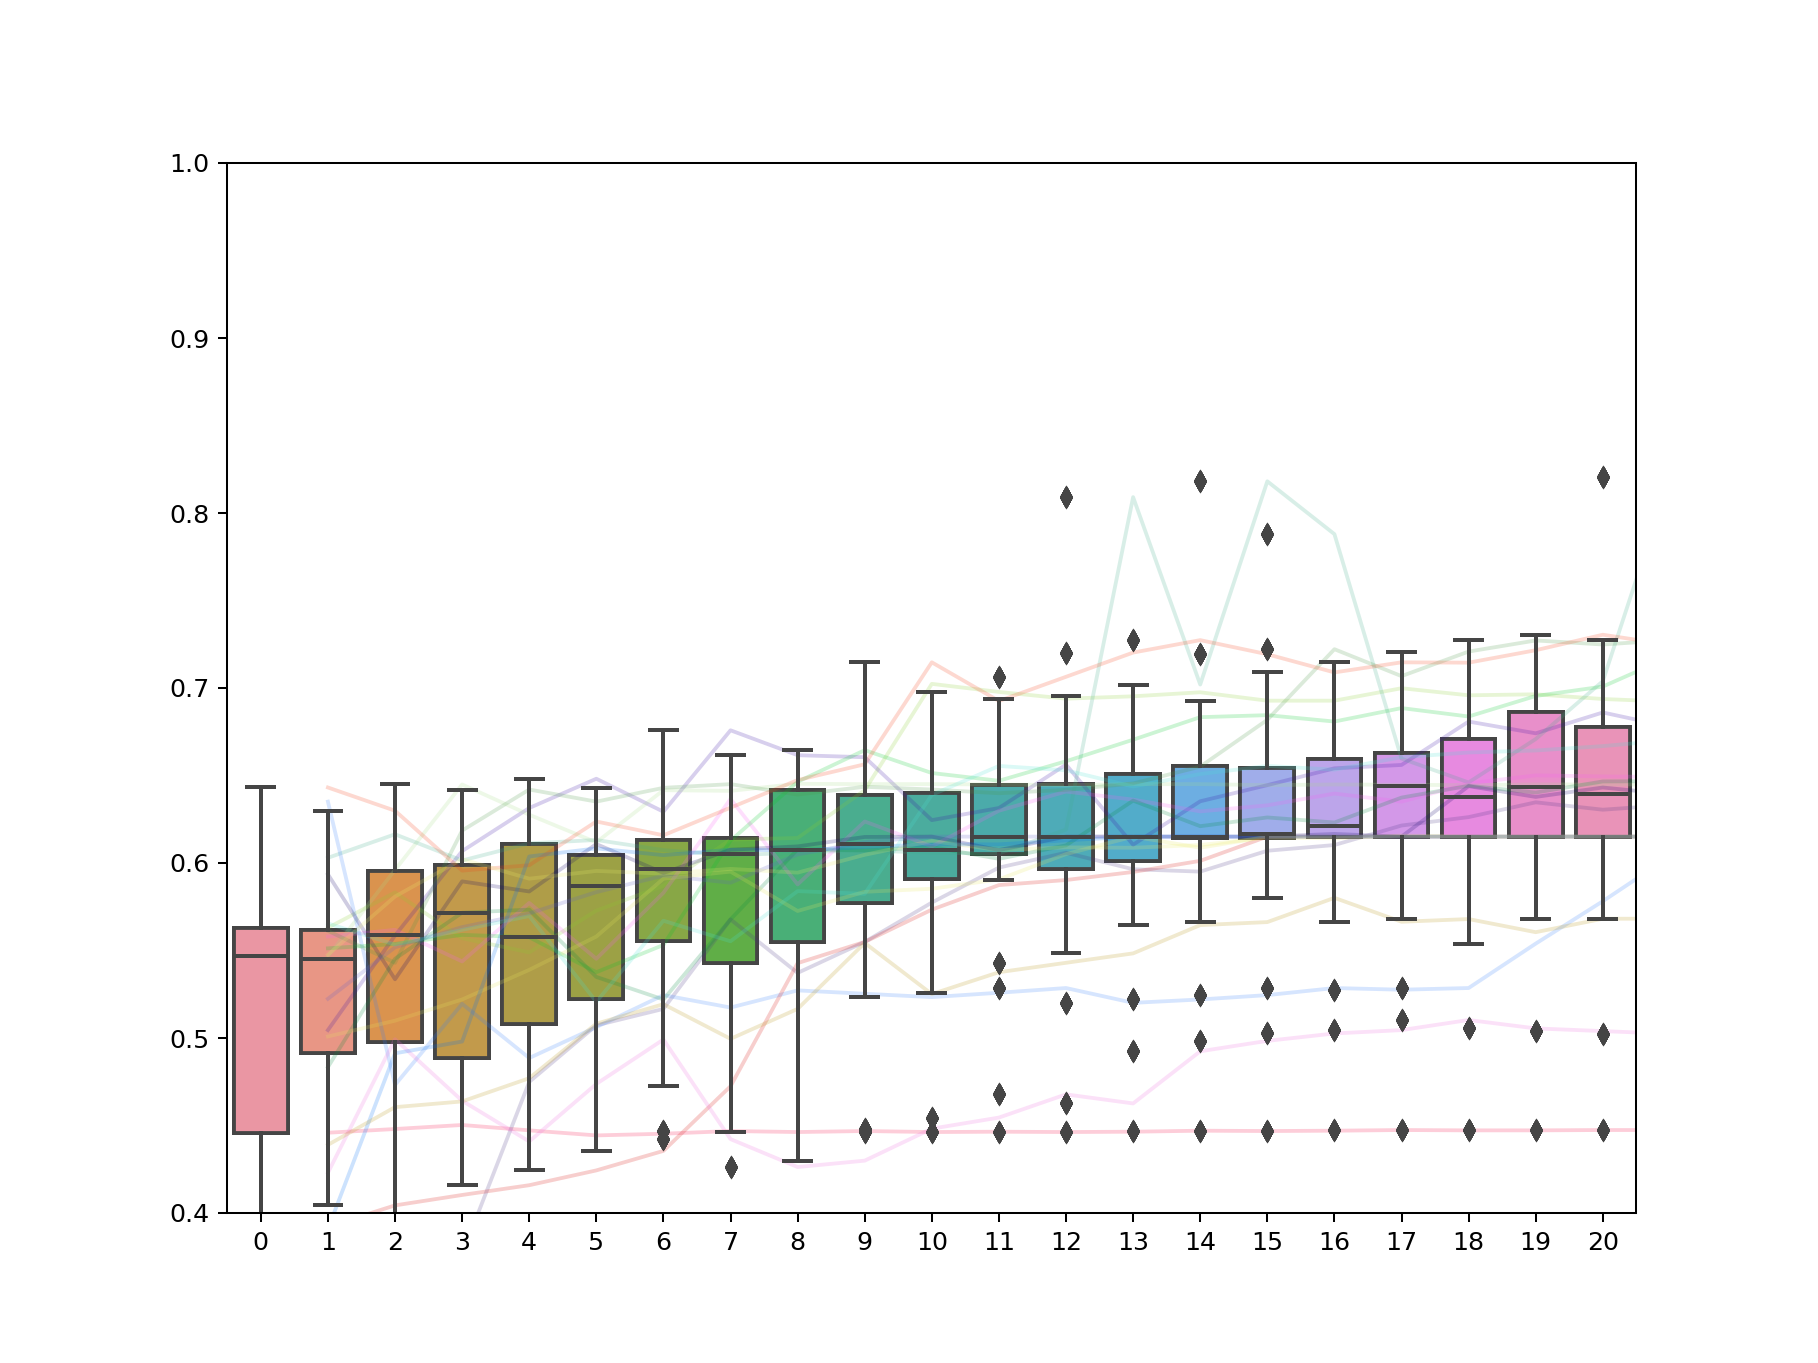

In [12]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns

# define a and b here
a = tst
b = []
for i in range(21):
    b.append(i+1)

# Helps pick a random color for each plot, used for readability
rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.set(ylim=(0.4, 1))
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr, alpha = 0.2)
    sns.boxplot(data=tst)